**Clasificación utilizando XGBoost (Core)**


Objetivo: Implementar un pipeline completo de machine learning para un problema de clasificación utilizando XGBoost. Se hará especial énfasis en el Análisis Exploratorio de Datos (EDA), preprocesamiento, entrenamiento del modelo y optimización de hiperparámetros.

**Dataset: Heart Disease UCI**

Descripción del Dataset: El dataset de enfermedades del corazón de la UCI contiene información sobre varios factores de riesgo asociados con enfermedades cardíacas. El objetivo es predecir la presencia de enfermedad cardíaca basándose en estos factores.

# Parte 1: Carga y Exploración Inicial de Datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Carga del Dataset:
* Cargar el dataset desde Kaggle

In [3]:
# cargar el dataset
data = pd.read_csv('../data/heart.csv')


## Exploración Inicial:
* Revisar la estructura del dataset.
* Describir las variables y su distribución.
* Identificar y documentar valores faltantes y outliers.

In [4]:
print(data.shape)
print(data.columns)
data.info()
data.head(5)

(303, 14)
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
print("Valores faltantes:", data.isnull().sum())

Valores faltantes: age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


# Parte 2: Análisis Exploratorio de Datos (EDA)

## Análisis Estadístico Descriptivo:
* Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
* Analizar la distribución de las variables categóricas.

In [6]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Visualizaciones:
* Crear histogramas y gráficos de barras para entender la distribución de las variables.
* Crear un mapa de calor para visualizar las correlaciones entre las variables.
* Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.

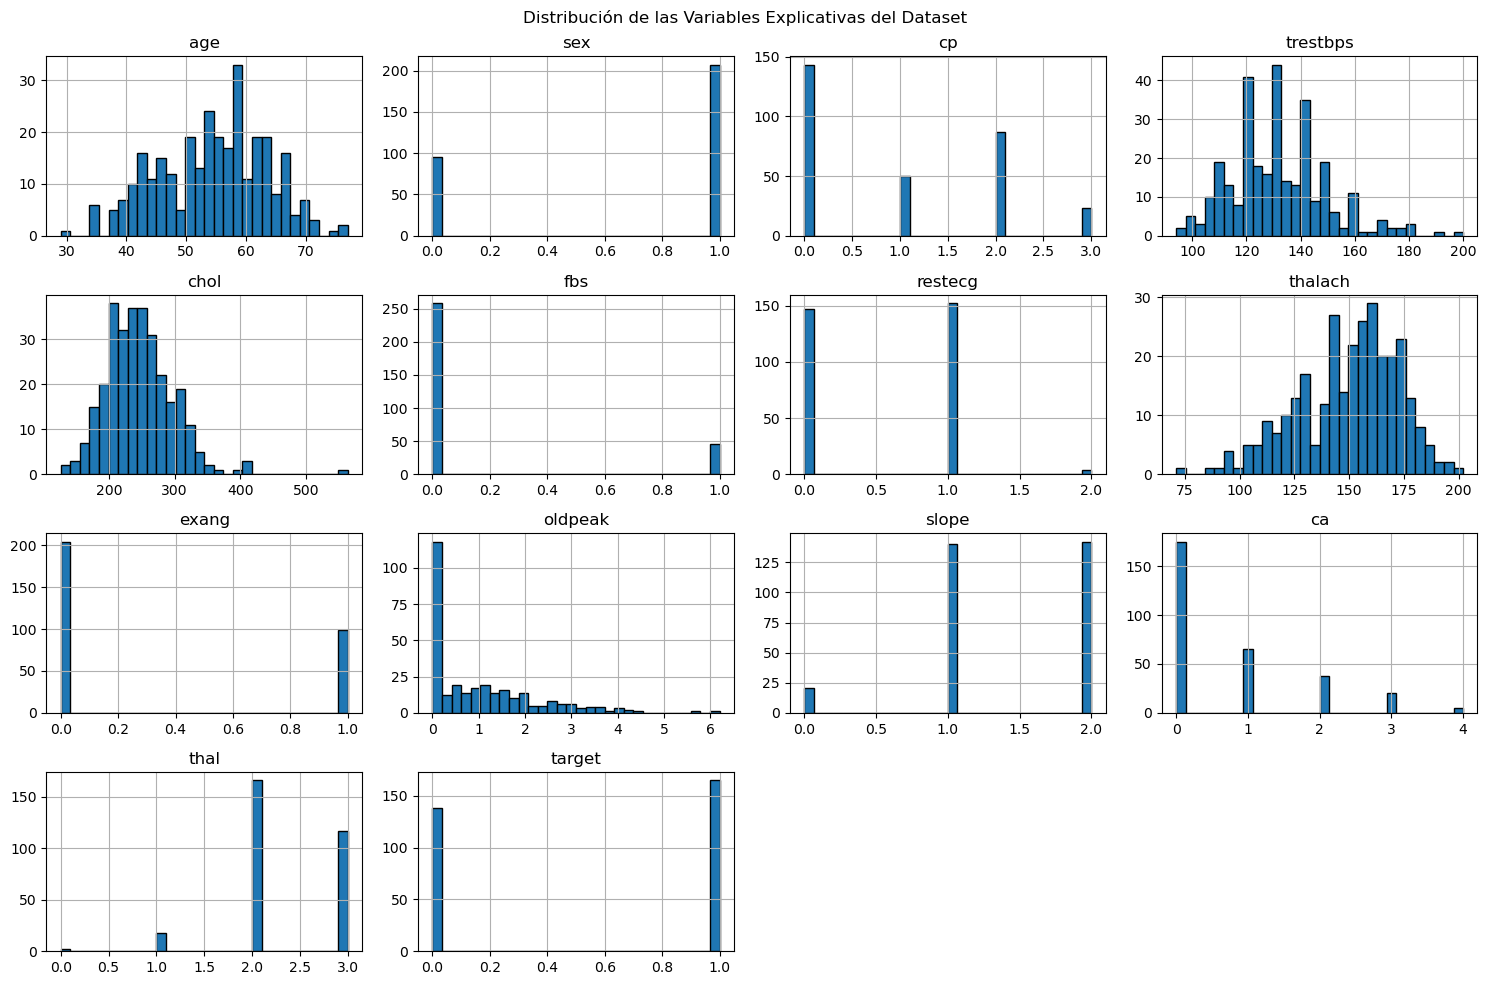

In [7]:
# Crear histogramas para cada característica
data.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Distribución de las Variables Explicativas del Dataset')
plt.tight_layout()
plt.show()

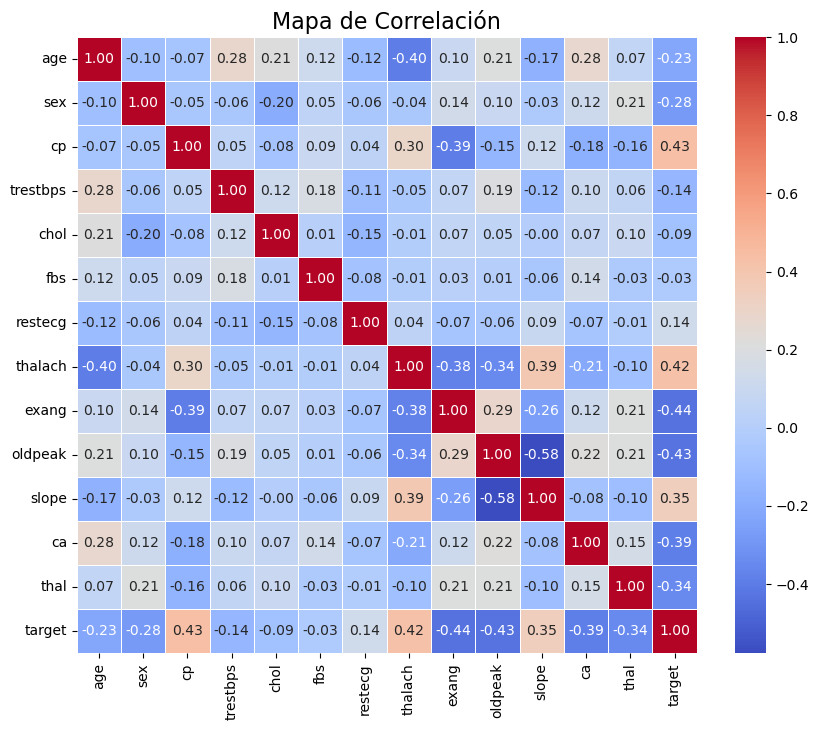

In [8]:
# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Crear un mapa de calor usando Seaborn
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura según sea necesario
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Añadir título al mapa de calor
plt.title('Mapa de Correlación', fontsize=16)
plt.show()

In [ ]:
# No hay outliers ni valores faltantes

# Parte 3: Preprocesamiento de Datos

## Transformación de Columnas:
* Codificar variables categóricas utilizando One-Hot Encoding.
* Escalar características numéricas utilizando StandardScaler.
* Dividir el dataset en conjuntos de entrenamiento y prueba.

In [11]:
# Separar las características (X) y el target (y)
X = data.drop(columns=['target'])  # Variables predictoras
y = data['target']                 # Variable objetivo

# Dividir el dataset en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()

# Ajustar el escalador solo al conjunto de entrenamiento y transformar ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parte 4: Implementación de XGBoost

## Entrenamiento del Modelo:
* Entrenar un modelo de XGBoost con hiperparámetros básicos.
* Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.

In [12]:
# Crear una instancia del clasificador XGBoost
xgb_model = XGBClassifier(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
xgb_model.fit(X_train_scaled, y_train)

# Predecir con el conjunto de prueba
y_pred = xgb_model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nExactitud del modelo:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Matriz de confusión:
[[32  9]
 [ 8 42]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        41
           1       0.82      0.84      0.83        50

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91


Exactitud del modelo:
Accuracy: 0.81


## Optimización de Hiperparámetros:

Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de XGBoost.

In [15]:
# Definir los hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],       # Número de árboles
    'learning_rate': [0.01, 0.1, 0.2],   # Tasa de aprendizaje
    'max_depth': [3, 6, 9],              # Profundidad máxima
    'subsample': [0.8, 1.0],             # Fracción de muestras para entrenar cada árbol
    'colsample_bytree': [0.8, 1.0],      # Fracción de características utilizadas por árbol
}

# Crear el modelo base
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=5,                # Validación cruzada (5 particiones)
    verbose=1,           # Mostrar progreso
    n_jobs=-1            # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Obtener el modelo optimizado
optimized_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores Hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


## Evaluación del Modelo Optimizado:

Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.


In [16]:
# Predecir con el modelo optimizado
y_pred_optimized = optimized_model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo optimizado
print("\nMatriz de confusión (Modelo Optimizado):")
print(confusion_matrix(y_test, y_pred_optimized))

print("\nReporte de clasificación (Modelo Optimizado):")
print(classification_report(y_test, y_pred_optimized))

print("\nExactitud del modelo optimizado:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.2f}")

# Comparación con el modelo inicial
print("\nComparación de exactitud:")
accuracy_initial = accuracy_score(y_test, y_pred)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Modelo Inicial: {accuracy_initial:.2f}")
print(f"Modelo Optimizado: {accuracy_optimized:.2f}")


Matriz de confusión (Modelo Optimizado):
[[31 10]
 [ 6 44]]

Reporte de clasificación (Modelo Optimizado):
              precision    recall  f1-score   support

           0       0.84      0.76      0.79        41
           1       0.81      0.88      0.85        50

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91


Exactitud del modelo optimizado:
Accuracy: 0.82

Comparación de exactitud:
Modelo Inicial: 0.81
Modelo Optimizado: 0.82
